In [ ]:
#!pip install numpy

# Outline
  - [ 1 - Import libraries ](#1)
  - [ 2 - Load dataset ](#2)
  - [ 3 - Analyzing text statistic ](#3)
  - [ 4 - Ngram exploration ](#4)
  - [ 5 - Wordcloud ](#5)

<a name='1'></a>
## 1 -  Import all libraries required for analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<a name='2'></a>
## 2 - Load dataset


In [4]:
df_training = pd.read_json('/content/drive/MyDrive/Colab Notebooks/raw/training.json', lines=True)
df_val = pd.read_json('/content/drive/MyDrive/Colab Notebooks/raw/validation_data.json', lines=True)


In [8]:
print("                                 Training data set")
print("training.json shape: ",df_training.shape)
print(df_training.info())
print()
print("                                 Validation data set")
print("validation_data.json shape: ",df_val.shape)
print(df_val.info())

                                 Training data set
training.json shape:  (18000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  int64 
 2   id      18000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 422.0+ KB
None

                                 Validation data set
validation_data.json shape:  (2000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   text    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


### Comment:
The training dataset contains three columns, text, label and id. And the text are sorted by id and the validation set contains two; id and text.



In [18]:

ai_text = df_training[df_training['label']==1]
print('# AI text:', len(ai_text))
print("                                 Sample AI text")
print(ai_text.iloc[0].text)

print()
human_text = df_training[df_training['label']==0]
print('# Human text:', len(human_text))
print("                                 Sample Human text")

print(human_text.iloc[0].text)

# AI text: 9000
                                 Sample AI text
Have you ever heard of the Crusades? A time in which Christians went on a 200 year rampage throughout Europe and on their path to Isreal in which they slaughtered innocent people in the name of your God?

# Human text: 9000
                                 Sample Human text
The Circuit Court of Appeals of New Jersey had jurisdiction of the controversy between these parties, and its decree was affirmed. But as the court had jurisdiction under the original act of Congress, the jurisdiction in this case was also, under the act of Congress, a bar to the suit.


<a name='3'></a>
## 3 - Analyzing text statistics


*   word frequency
*   sentence length  
*   average word length



<Axes: >

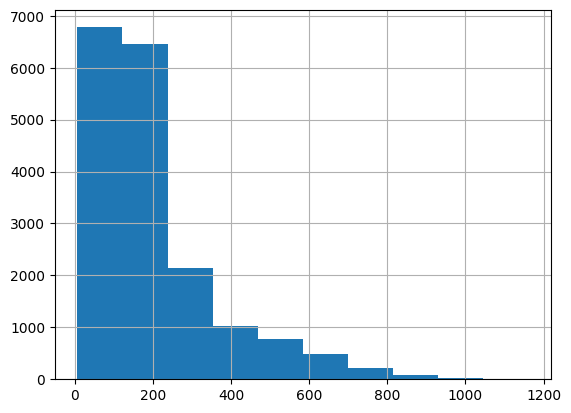

In [19]:
df_training['text'].str.len().hist()
# df_val['text'].str.len().hist()

### Comment:
Text range from 0 to 1200 characters and generally between 0 to 600 characters.

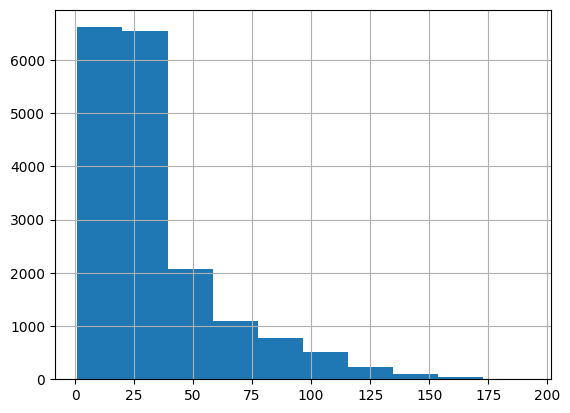

In [ ]:
def plot_num_word_hist(text):
  text.str.split().map(lambda x: len(x)).hist()

plot_num_word_hist(df_training['text'])

### Comment:
Words in text ranges from 0 to 175 and generally between 0 and 100 words

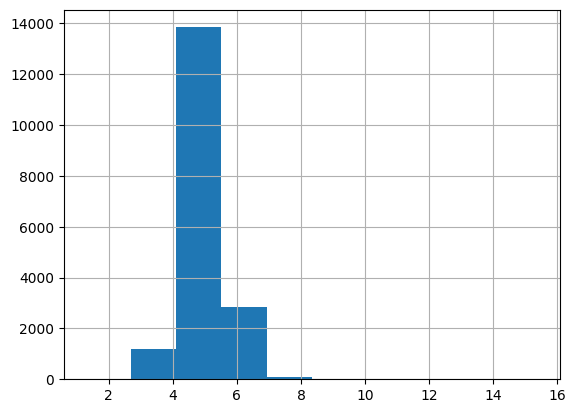

In [ ]:
def avg_word_len_hist(text):
  text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

avg_word_len_hist(df_training['text'])

### Comment:
Average word length ranges from 3 to 8 with 5 being most common length.

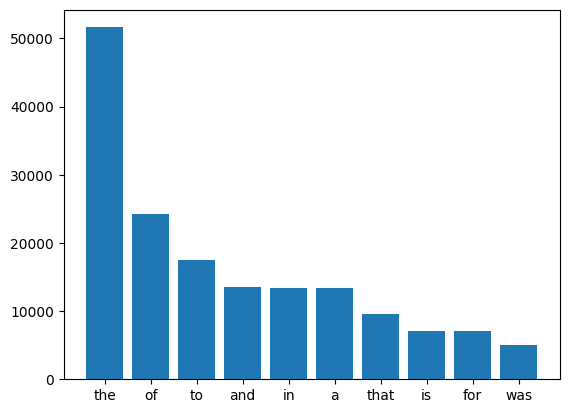

In [ ]:

def plot_stopwords(text):
    stop_words=set(stopwords.words('english'))

    text = text.str.split() # split sentense into word list
    text = text.values.tolist() # convert to a list
    corpus = [word for i in text for word in i]
    corpus = [item.lower() for item in corpus]
    dictionary = defaultdict(int)
    for word in corpus:
        if word in stop_words:
          dictionary[word] += 1 # count stopwords

    top=sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)

plot_stopwords(df_training['text'])

Top use stopwords are 'the', 'of' and 'to' in text

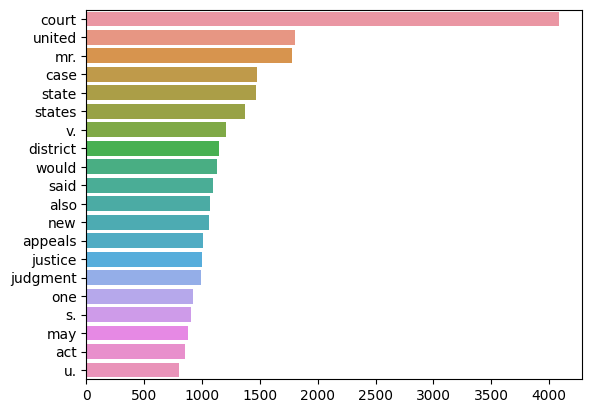

In [ ]:
def plot_top_non_stopwords(text):
    stop_words=set(stopwords.words('english'))

    text = text.str.split() # split sentense into word list
    text = text.values.tolist() # convert to a list
    corpus = [word for i in text for word in i]
    corpus = [item.lower() for item in corpus]
    counter = Counter(corpus)
    most = counter.most_common() # returns a list of all elements and their counts

    w, c = [], []
    display_limit = 20
    for word, count in most:
        if display_limit == 0:
            break
        if (word not in stop_words):
            w.append(word)
            c.append(count)
            display_limit -=1
    sns.barplot(x=c, y=w)

plot_top_non_stopwords(df_training['text'])

### Comment:
Most frequent non-stop words: "Court" and "United"

<a name='4'></a>
## 4 - Ngram exploration
Explore most frequent contiguous sequences of n words to get a better understanding of the context.

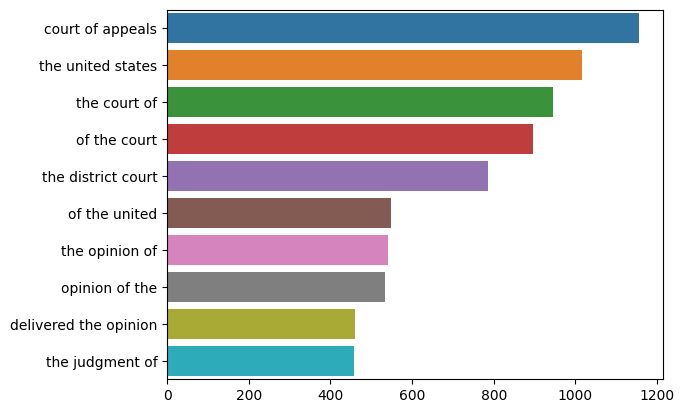

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df_training['text'], 3)


### Comment
...

<a name='5'></a>
## 5 - Wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


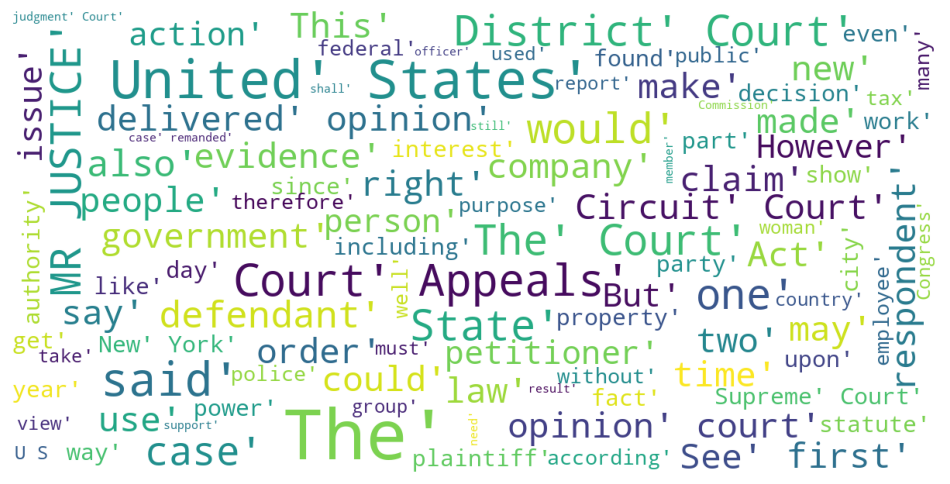

In [ ]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()


plot_wordcloud(df_training['text'])